# Chip Classification using EuroSAT - Predict

This notebook demonstrates prediction using a chip classifier trained in `train-eurosat` on a Sentinel 2 dataset called [EuroSAT](https://github.com/phelber/EuroSAT). Note that using the [wandb logger](https://wandb.ai/) only requires a free account

## Environment Setup 

Refer to README.md for environment setup. 

In [ ]:
import os

# If using LightningAI, change the current working directory to the directory containing this notebook. 
REPO_DIR = "/teamspace/studios/this_studio/eda-bids-hackathon-prep/"  # Adjust as appropriate
if os.path.exists(REPO_DIR):
    os.chdir(os.path.join(REPO_DIR, "sentinel2-modelling"))

# If you encounter a warning regarding gdal mising GDAL_DATA, run the following 
if os.environ.get('CONDA_PREFIX') is not None: 
    if os.environ.get('GDAL_DATA') is None: 
        os.environ['GDAL_DATA'] = os.environ["CONDA_PREFIX"] + r"\Library\share\gdal"
    if os.environ.get('PROJ_LIB') is None: 
        os.environ['PROJ_LIB'] = os.environ["CONDA_PREFIX"] + r"\Library\share\proj"

In [1]:
import os
import tempfile
from typing import Dict, Optional, Any
from typing import Callable, Optional, cast
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch import Tensor
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import NonGeoDataModule
from torchgeo.transforms import AugmentationSequential, indices
from torchgeo.trainers import ClassificationTask
from torchgeo.models import ResNet18_Weights

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

seed_everything(543)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Load EDS credentials from .env file
from dotenv import load_dotenv
load_dotenv()

Global seed set to 543


cpu


## Predictions

Having trained a model from the `train-eurosat` notebook, we will now predict with it

In [2]:
class EuroSATDataModule(NonGeoDataModule):
    """LightningDataModule implementation for the EuroSAT dataset.

    Uses the train/val/test splits from the dataset.

    .. versionadded:: 0.2
    """

    mean = torch.zeros(13)
    std = torch.ones(13)

    def __init__(
        self, batch_size: int = 64, num_workers: int = 0, **kwargs: Any
    ) -> None:
        """Initialize a new EuroSATDataModule instance.

        Args:
            batch_size: Size of each mini-batch.
            num_workers: Number of workers for parallel data loading.
            **kwargs: Additional keyword arguments passed to
                :class:`~torchgeo.datasets.EuroSAT`.
        """
        super().__init__(EuroSAT, batch_size, num_workers, **kwargs)

In [3]:
if device == "cuda":
    batch_size = 128
    num_workers = 8
elif device ==  "cpu":
    batch_size = 64
    num_workers = 0
else:
    print("unknown device!")

datamodule = EuroSATDataModule(
    batch_size=batch_size, 
    root="data", 
    num_workers=num_workers, 
    download=True,
)

Download a model checkpoint from wandb or point to a local checkpoint - note an [issue](https://github.com/microsoft/torchgeo/issues/1639) with the SENTINEL2_ALL_MOCO & RGB weights 

In [4]:
ckpt_path = 'eda-eurosat/model.ckpt'
ckpt_path

'eda-eurosat/model.ckpt'

In [5]:
task = ClassificationTask.load_from_checkpoint(ckpt_path, map_location=torch.device(device))

In [6]:
datamodule.setup(stage="test")

In [7]:
trainer = Trainer(
    # limit_predict_batches=1 # for a single batch only
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
test_results = trainer.test(model=task, dataloaders=datamodule) # 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.9373579025268555     │
│       test_F1Score        │    0.9379629492759705     │
│     test_JaccardIndex     │    0.8812095522880554     │
│   test_OverallAccuracy    │    0.9379629492759705     │
│         test_loss         │    0.2179727703332901     │
└───────────────────────────┴───────────────────────────┘

# Inference a single image
Note that since the data was not normalised prior to training, it is possible to pass through an image without normalisation, but we will do so to be safe

CPU times: user 49.8 ms, sys: 6.53 ms, total: 56.4 ms
Wall time: 58.6 ms


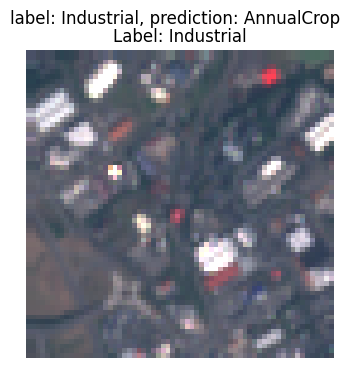

In [9]:
%%time
sample = datamodule.test_dataset[2500]
label = cast(int, sample["label"].item())
image = sample['image'].unsqueeze(0).to(device)
pred = task(image)
pred_index = int(torch.argmax(pred))

result_str = f"label: {datamodule.test_dataset.classes[label]}, prediction: {datamodule.test_dataset.classes[pred_index]}"
fig = datamodule.test_dataset.plot(sample, suptitle=result_str)

## Generate confusion matrix

In [13]:
y_true = []
y_pred = []

task.eval()

with torch.no_grad():
    for batch in datamodule.test_dataloader():
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        preds = task(images)
        preds_indices = torch.argmax(preds, dim=1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds_indices)

In [14]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred) # , labels=datamodule.test_dataset.classes

cm

array([[584,   0,   4,   0,   0,   5,   3,   0,   0,   0],
       [  7, 600,   1,   0,   0,   0,   0,   0,   0,   0],
       [ 12,  45, 428,   1,   0,  68,  13,   1,   5,   0],
       [ 12,   2,   4, 444,   3,   9,   6,   7,   9,   0],
       [  1,   0,   0,   7, 446,   0,   3,  41,   3,   0],
       [  8,  16,   1,   0,   0, 370,   1,   0,   0,   0],
       [ 37,   4,  14,   3,   0,  20, 459,   1,   0,   0],
       [  0,   1,   0,   3,   2,   1,   5, 542,   0,   0],
       [  3,   0,   0,   4,   0,   0,   0,   0, 517,   5],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2, 607]])

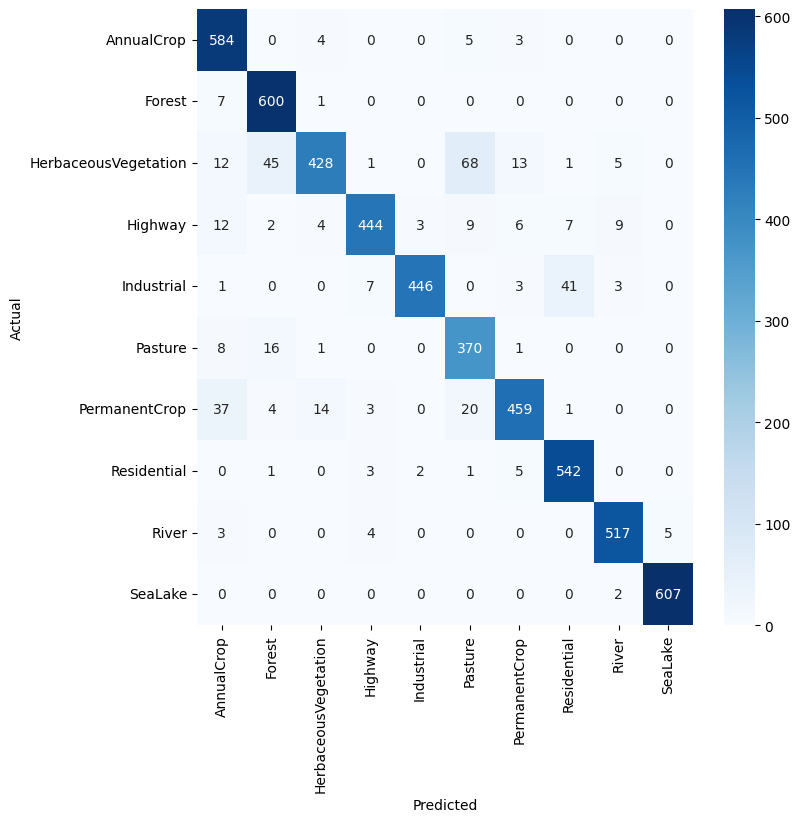

In [15]:
# Define function to plot confusion matrix
def plot_confusion_matrix(cm, labels):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, datamodule.test_dataset.classes)